In [1]:
using BeamPropagation, 
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018,
    Plots,
    Parameters,
    LinearAlgebra
;

In [2]:
# Define physical constants
const kB = BoltzmannConstant.val

# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const v_recoil = @with_unit 1.1 "cm/s"
;

In [3]:
Base.@kwdef struct AsymmetricGaussianTrap
    λ::Float64
    w0x::Float64
    w0y::Float64
    U_max::Float64
    m::Float64    
    zRx::Float64 = π * w0x^2 / λ
    zRy::Float64 = π * w0y^2 / λ
    ω::SVector{3, Float64} = SVector( sqrt(4*U_max/(m*w0x^2)), sqrt(4*U_max/(m*w0y^2)), sqrt(2*U_max/(m*zRx*zRy)) )
end;

In [4]:
# Define tweezer beam properties
const T_depth = @with_unit 1 "mK"
const U_max = kB * T_depth

const λ = 780e-9

const w0x = 1.9e-6
const w0y = 1.9e-6
const zRx = π * w0x^2 / λ
const zRy = π * w0y^2 / λ

# const ωx = 2π * 120e3/2
# const ωy = 2π * 120e3/2
# const ωz = sqrt(2 * U_max / (m * zRx^2))
# const ω = SVector(ωx, ωy, ωz)
trap_780nm = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
ω_crossed = SVector(trap_780nm.ω[3], trap_780nm.ω[2], trap_780nm.ω[1])
trap_780nm_crossed = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m, ω=ω_crossed)
;

### Potential and force for an ODT assuming a Gaussian beam profile

In [5]:
wx(z, trap) = trap.w0x * sqrt(1 + z^2 / trap.zRx^2)
wy(z, trap) = trap.w0y * sqrt(1 + z^2 / trap.zRy^2)
;

In [6]:
wx(z, trap) = trap.w0x * sqrt(1 + z^2 / trap.zRx^2)
wy(z, trap) = trap.w0y * sqrt(1 + z^2 / trap.zRy^2)
function F(x, y, z, trap)
    λ, w0x, w0y, zRx, zRy = trap.λ, trap.w0x, trap.w0y, trap.zRx, trap.zRy
    
    wx_ = wx(z, trap)
    wy_ = wy(z, trap)
    exp_term = exp(-2(x^2 / wx_^2 + y^2 / wy_^2))
    denom_term_x = wx_^2 * sqrt(1 + (z/zRx)^2) * sqrt(1 + (z/zRy)^2)
    denom_term_y = wy_^2 * sqrt(1 + (z/zRx)^2) * sqrt(1 + (z/zRy)^2)
    
    F_x = 4x / denom_term_x
    F_y = 4y / denom_term_y
    F_z = z * (w0x / zRx)^2 / denom_term_x + z * (w0y / zRy)^2 / denom_term_y -
        (4 * x^2 * z) / (denom_term_x * zRx^2 * (1 + (z/zRx)^2)) - (4 * y^2 * z) / (denom_term_y * zRy^2 * (1 + (z/zRy)^2))

    return -exp_term .* SVector(F_x, F_y, F_z)
end
F(r, trap) = F(r[1], r[2], r[3], trap)
function F_crossed(r, trap)
    F_ = F(r[3], r[2], r[1], trap)
    return SVector(F_[3], F_[2], F_[1])
end
;

In [7]:
function waist(z,w0,zR,z0)
    w0 * sqrt(1 + ((z-z0) / zR)^2)
end

function U(r, trap)
    w0x, w0y, zRx, zRy = trap.w0x, trap.w0y, trap.zRx, trap.zRy
    x, y, z = r
    
    wx = waist(z, w0x, zRx, 0)
    wy = waist(z, w0y, zRy, 0)
    return trap.U_max * (1 - ((w0x * w0y) / (wx * wy)) * exp(-2 * (x^2 / wx^2 + y^2 / wy^2)))
end;

In [8]:
function make_distributions(T, trap)
    σ = sqrt(kB * T / m)
    σ_rx = σ / trap.ω[1]
    σ_ry = σ / trap.ω[2]
    σ_rz = σ / trap.ω[3]
    σ_vx = σ_vy = σ_vz = σ
    r = (Normal(0, σ_rx), Normal(0, σ_ry), Normal(0, σ_rz))
    v = (Normal(0, σ_vx), Normal(0, σ_vy), Normal(0, σ_vz))
    a = (Normal(0, 0), Normal(0, 0), Normal(0, 0))
    return r, v, a #, E
end
;

In [9]:
# struct HarmonicTrapEnergy <: Sampleable{Univariate, Continuous}
    # T::Float64
# end
# pdf(d, E) = exp(-E / (k_B * T)) * E^2 / (2 * (k_B * T)^3)
# logpdf(d, E) = 
# function rand(rng::AbstractRNG, 
    # sample = rand(rng, 
# function harmonic_E_dist(T)

### Simulation of shaving and then imaging

In [212]:
@consts begin
    n = 1000
    save_every = 100
    delete_every = 50
    dt_min = 1e-10
    dt_max = 1e-4
    abstol = 1e-5
    dt = 1e-7
    end_time = @with_unit 200 "ms"
    max_steps = end_time / dt
    alg = "rkf12"
    use_adaptive = false
    n_saves = round(Int, max_steps / save_every)
end
;

In [213]:
function uniform_direction()
    # See https://mathworld.wolfram.com/SpherePointPicking.html
    u = 1 - 2*rand()
    θ = 2π * rand()
    return SVector(sqrt(1-u^2)*cos(θ), sqrt(1-u^2)*sin(θ), u)
end;

In [214]:
# Return a linear cooling force, with damping coefficient η and offset from zero velocity by v0
linear_cooling_force(η, v, v0) = -η*(v - v0);

In [215]:
discard(r, v) = false
is_detectable(r, trap) = ~((abs(r[1]) > 10trap.w0x) || (abs(r[2]) > 10trap.w0y) || (abs(r[3]) > 10max(trap.zRx, trap.zRy)))

function update(particles, p, s, dt, time, idx)
    
    for i in eachindex(particles)
        particle_idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[particle_idx] = is_detectable(r, p.trap)
        
        if p.imaging_start_time < time < p.imaging_end_time
            v = particles.v[i]
            v_scalar = norm(v) / sqrt(3 * (kB * T) / m)
            scatter_prob = p.R_scatt * dt * v_scalar
            spont_recoil = v_recoil .* uniform_direction()
            if rand() < scatter_prob
                particles.v[i] += spont_recoil
                s.scattered_photons[particle_idx][1+div(idx-1, save_every)] += s.detectable[particle_idx]
            end
        end
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)

function f(idx, r, v, p, time)

    # Calculate cooling/imaging force
    if p.imaging_start_time < time < p.imaging_end_time
        F_cooling_x = m * linear_cooling_force(p.a_cool, v[1], 0)
        F_cooling_y = m * linear_cooling_force(p.a_cool, v[2], 0)
        F_cooling_z = m * linear_cooling_force(p.a_cool, v[3], 0)

        # Adjust the cooling force such that it accounts for beam weights
        F_cooling = SVector(
            F_cooling_x * p.beam_weights[(sign(v[1]) == -1) + 1], 
            F_cooling_y * p.beam_weights[(sign(v[2]) == -1) + 3],
            F_cooling_z * p.beam_weights[(sign(v[3]) == -1) + 5]
            )
    else
        F_cooling = SVector(0.,0.,0.)
    end
    
    # Calculate trapping force
    if p.shaving_start_time < time < p.shaving_end_time
        U_depth = p.shaved_U_depth
    else
        U_depth = p.trap.U_max
    end
    F_trap = F(r, p.trap) * U_depth / m
    
    return F_trap + (F_cooling / m) + gravity(r)
end

function save(particles, p, s)
    for i in eachindex(particles)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
        push!(s.velocities[idx], particles.v[i])
        push!(s.survived[idx], s.detectable[idx])
    end
    return nothing
end
;

In [216]:
# Old parameter settings
# Tweezer, cold
# const T = @with_unit 70 "μK"
# R_scatt = 16e3
# a_cool = 100
# trap_ = trap_780nm

# Tweezer, hot
# const T = @with_unit 140 "μK"
# R_scatt = 12e3
# a_cool = 40
# trap_ = trap_780nm

# ODT, cold
# const T = @with_unit 30 "μK"
# R_scatt = 50e3
# a_cool = 700
# trap_ = trap_ODT

# ODT, hot
# const T = @with_unit 60 "μK"
# R_scatt = 35e3
# a_cool = 350
# trap_ = trap_ODT

In [217]:
# Simulation parameters
# Tweezer, 45e3 scattering rate
const T = @with_unit 300 "μK"
R_scatt = 40e3
a_cool = 30
trap_ = trap_780nm
imaging_start_time = @with_unit 70 "ms"
imaging_end_time = @with_unit 70 + 100 "ms"

shaved_T_depth = @with_unit 500 "μK"
shaved_U_depth = kB * shaved_T_depth
shaving_start_time = @with_unit 30 "ms"        # Start of shaving
shaving_end_time = @with_unit 30 + 20 "ms"     # End of shaving

x̂ = SVector(1,0,0)
ŷ = SVector(0,1,0)
ẑ = SVector(0,0,1)
directions = [-x̂, x̂, -ŷ, ŷ, -ẑ, ẑ]
beam_weights = Weights([1, 1, 1, 1, 1, 1])
beam_weights = Weights(beam_weights / sum(beam_weights))
beam_direction = sum(directions[i] * beam_weights[i] for i ∈ 1:6)
;

In [218]:
detectable = zeros(Bool, n)
particles = StructArray{Particle}(undef, n)
trajectories = [SVector{3, Float64}[] for _ ∈ 1:n]
velocities = [SVector{3, Float64}[] for _ ∈ 1:n]
scattered_photons = [zeros(Float64, n_saves) for _ ∈ 1:n]
survived = [Bool[] for _ ∈ 1:n]

r, v, a = make_distributions(T, trap_)

p = MutableNamedTuple(
    R_scatt=R_scatt, 
    a_cool=a_cool, 
    directions=directions, 
    beam_weights=beam_weights, 
    trap=trap_,
    cooling_left=cooling_left, 
    dt=dt,
    imaging_start_time=imaging_start_time,
    imaging_end_time=imaging_end_time,
    shaved_U_depth=shaved_U_depth,
    shaving_start_time=shaving_start_time,
    shaving_end_time=shaving_end_time)

s = MutableNamedTuple(
    detectable=detectable,
    trajectories=trajectories, 
    velocities=velocities, 
    scattered_photons=scattered_photons,
    survived=survived)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)
mean(s.detectable) |> display

 51.575962 seconds (166.70 k allocations: 1.915 GiB, 3.71% compilation time: 13% of which was recompilation)


0.095

In [219]:
temperatures = [mean([m * norm(s.velocities[i][j])^2 / (3kB) for i ∈ 1:n]) for j ∈ 1:n_saves]
temperatures_detectable = [mean([m * norm(s.velocities[i][j])^2 / (3kB) for i ∈ 1:n if survived[i][j]]) for j ∈ 1:n_saves]
;

In [220]:
survived_t = mean(survived)
scattered_photons_t = mean([cumsum(scattered_photons) for scattered_photons ∈ s.scattered_photons])
;

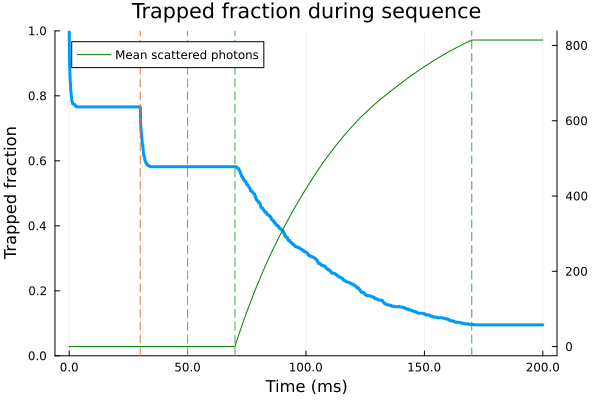

In [221]:
plot(times, survived_t, linewidth=3)
plot!(
    title="Trapped fraction during sequence",
    ylim=(0,1),
    xlabel="Time (ms)",
    xticks=(0:0.25end_time:end_time, 1e3 .* (0:0.25end_time:end_time)),
    ylabel="Trapped fraction",
    legend=nothing
    )
idx_after_shaving = round(Int, (shaving_end_time / dt) / save_every)
plot!(twinx(), times, scattered_photons_t ./ survival[idx_after_shaving], color=:green, label="Mean scattered photons")
vline!([shaving_start_time, shaving_end_time], linestyle=:dash)
vline!([imaging_start_time, imaging_end_time], linestyle=:dash)

In [222]:
println("Scattered photons per molecule (for molecules surviving the shave): ", scattered_photons_t[end] / survival[5000])

Scattered photons per molecule (for molecules surviving the shave): 814.3472222222223


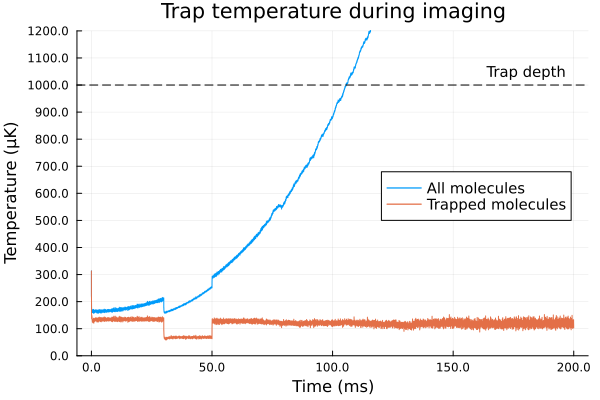

In [223]:
# Plot of temperature for all molecules
plot(times, temperatures, label="All molecules")

# Plot temperature of molecules that have survived up to that point
plot!(times, temperatures_detectable, label="Trapped molecules")

# Plot settings
T_depth = trap_.U_max / kB
hline!([T_depth], linestyle=:dash, color="black", label=nothing)
annotate!(0.9end_time, 1.05T_depth, text("Trap depth", 10))
plot!(
    title="Trap temperature during imaging",
    ylim=(0, 1.2T_depth),
    xlabel="Time (ms)",
    xticks=(0:0.25end_time:end_time, 1e3 .* (0:0.25end_time:end_time)),
    ylabel="Temperature (μK)",
    yticks=(0:(0.1T_depth):1.2T_depth, (0:(0.1T_depth):1.2T_depth) .* 1e6),
    legend=:right,
    legendfont=10
)

### Scanning parameters

In [224]:
using Parameters

In [225]:
function run_simulation(p)
    
    # Create arrays for data to be saved
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:n]
    velocities = [SVector{3, Float64}[] for _ ∈ 1:n]
    scattered_photons = [zeros(Float64, n_saves) for _ ∈ 1:n]
    survived = [Bool[] for _ ∈ 1:n]
    
    s = MutableNamedTuple(
        detectable=detectable, 
        trajectories=trajectories, 
        velocities=velocities, 
        scattered_photons=scattered_photons,
        survived=survived)
    
    r, v, a = make_distributions(T, p.trap)

    particles = StructArray{Particle}(undef, n)
    @time propagate_particles!(r, v, a, 
        alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true
    )
    
    # Survival after shaving
    idx_after_shaving = round(Int, (shaving_end_time / dt) / save_every)
    survived = mean([survived[idx_after_shaving] for survived ∈ s.survived])
    
    # Mean photons scattered by surviving molecules
    scattered_photons_t = mean([cumsum(scattered_photons) for scattered_photons ∈ s.scattered_photons])
    
    return (survived, scattered_photons_t[end])
end;

In [ ]:
shaved_U_depths = (0:0.1:1) .* U_max

mean_survival = Float64[]
mean_photons = Float64[]

@time for shaved_U_depth ∈ shaved_U_depths
    
    # Create parameters and saved variables, and update scanned parameters
    p_ = deepcopy(p)
    p_.shaved_U_depth = shaved_U_depth
    
    mean_survival_, mean_photons_ = run_simulation(p_)
    push!(mean_survival, mean_survival_)
    push!(mean_photons, mean_photons_)

end

 53.608631 seconds (24.52 k allocations: 1.906 GiB)
 52.254272 seconds (24.74 k allocations: 1.906 GiB)
 51.374008 seconds (24.74 k allocations: 1.906 GiB)
 51.998243 seconds (24.80 k allocations: 1.906 GiB)
 53.372394 seconds (24.80 k allocations: 1.906 GiB)
 87.211542 seconds (25.04 k allocations: 1.906 GiB, 2.10% gc time)
 54.126864 seconds (24.81 k allocations: 1.906 GiB)
 76.760590 seconds (24.85 k allocations: 1.906 GiB, 2.22% gc time)
 54.451931 seconds (24.80 k allocations: 1.906 GiB)
 82.623819 seconds (25.16 k allocations: 1.906 GiB, 2.00% gc time)
 49.081789 seconds (24.62 k allocations: 1.906 GiB)
672.022296 seconds (700.26 k allocations: 25.908 GiB, 1.18% gc time, 0.04% compilation time)


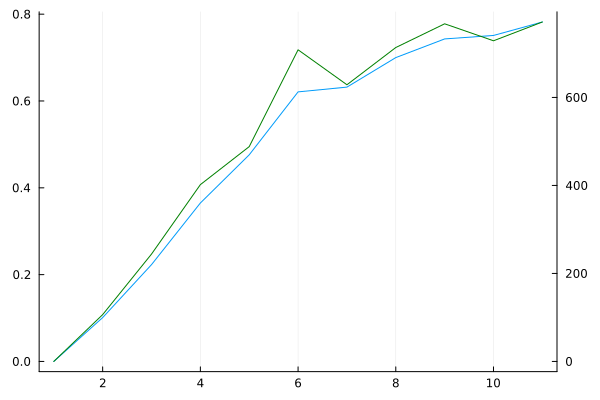

In [230]:
plot()
plot!(mean_survival)
plot!(legend=nothing)

plot!(twinx(), mean_photons, color=:green, legend=nothing)

In [ ]:
(1e-3 / 0.5e-6) / 30e3

0.06666666666666668